## Sensitivity analysis
- Partial correlation coefficient (PCC)
- Random Balance Design - Fourier Amplitude Sensitivity Test (RBD-FAST)

In [10]:
import os
import yaml

import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import sklearn.preprocessing as preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from SALib.analyze import rbd_fast
from palettable.colorbrewer.sequential import YlGn_9
from palettable.cmocean.sequential import Tempo_10
from palettable.colorbrewer.qualitative import Dark2_4
from palettable.cartocolors.qualitative import Pastel_4

from ideotype.data_process import read_sims, read_data, parse_mature
from ideotype.nass_process import read_nass, nass_summarize
from ideotype.init_params import params_sample
from ideotype.data_process import agg_sims
from ideotype import DATA_PATH

In [2]:
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    '/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_present.yml')
df_extended, df_stuck = parse_mature(df_all)
df_all.drop(df_stuck.index, inplace=True)

### Partial Correlation Coefficient

In [4]:
# set up mean
df_mean = df_all.groupby(['cvar','site']).mean().dm_ear
df_mean = df_mean.reset_index()
df_mean = df_mean.merge(df_params, how='left', on='cvar')

# Set up dispersion
df_disp = (df_all.groupby(['cvar','site']).var().dm_ear) / (df_all.groupby(['cvar','site']).mean().dm_ear)
df_disp = df_disp.reset_index()
df_disp = df_disp.merge(df_params, how='left', on='cvar')

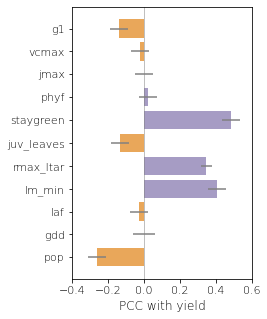

In [5]:
params_list = list(df_params.columns[:-1])
rs_mean = []
ps = []
cis = []

for item in np.arange(11):
    param = params_list[item]
    select = list(np.arange(11))
    select.remove(item)
    params_sub = [params_list[item] for item in select]
    pcc = pg.partial_corr(df_mean, x=param, y='dm_ear',
                          x_covar=params_sub)
    rs_mean.append(pcc['r']['pearson'])
    ps.append(pcc['p-val']['pearson'])
    cis.append(pcc['CI95%']['pearson'])

# set error bars
errs = [np.round(np.abs(cis[item][0] - cis[item][1]),2) for item in np.arange(len(cis))]

# set bar colors
cc = ['colors']*len(rs_mean)
for n, r in enumerate(rs_mean):
    if r < 0:
        cc[n] = '#e08214'
    if r > 0:
        cc[n] = '#8073ac'

# visualization
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.barh(list(reversed(params_list)), 
        list(reversed(rs_mean)), 
        color=list(reversed(cc)),
        xerr=errs, ecolor='grey', alpha=0.7)
ax.set_xlabel('PCC with yield', size=12, fontweight='light')
ax.set_xlim(-0.4, 0.6)

plt.axvline(x=0, color='grey', linewidth=0.5)
plt.xticks(fontsize=11, weight='light')
plt.yticks(fontsize=11, weight='light')
fig.subplots_adjust(left=0.3, right=0.8)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/pcc_mean.png', format='png', dpi=800)

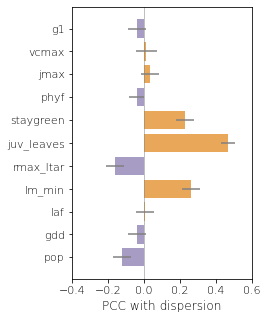

In [9]:
params_list = list(df_params.columns[:-1])
rs_disp = []
ps = []
cis = []

for item in np.arange(11):
    param = params_list[item]
    select = list(np.arange(11))
    select.remove(item)
    params_sub = [params_list[item] for item in select]
    pcc = pg.partial_corr(df_disp, x=param, y='dm_ear',
                          x_covar=params_sub)
    rs_disp.append(pcc['r']['pearson'])
    ps.append(pcc['p-val']['pearson'])
    cis.append(pcc['CI95%']['pearson'])

# set error bars
errs = [np.round(np.abs(cis[item][0] - cis[item][1]),2) for item in np.arange(len(cis))]

# set bar colors
cc = ['colors']*len(rs_disp)
for n, r in enumerate(rs_disp):
    if r < 0:
        cc[n] = '#8073ac'
    if r > 0:
        cc[n] = '#e08214'

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.barh(list(reversed(params_list)), 
        list(reversed(rs_disp)), 
        color=list(reversed(cc)),
        xerr=errs, ecolor='grey', alpha=0.7)
ax.set_xlim(-0.4, 0.6)
ax.set_xlabel('PCC with dispersion', size=12, fontweight='light')

plt.axvline(x=0, color='grey', linewidth=0.5)
plt.xticks(fontsize=11, weight='light')
plt.yticks(fontsize=11, weight='light')
fig.subplots_adjust(left=0.3, right=0.8)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/pcc_disp.png', format='png', dpi=800)

Text(0, 0.5, 'PCC with dispersion')

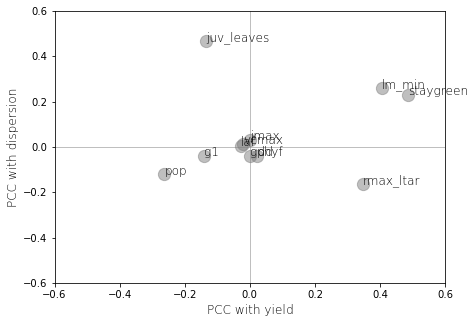

In [161]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
ax.scatter(rs_mean, rs_disp, s=150, color='grey', alpha=0.5)
ax.axvline(x=0, color='grey', linewidth=0.5)
ax.axhline(y=0, color='grey', linewidth=0.5)
for count, item in enumerate(params_list):
    ax.annotate(item, (rs_mean[count], rs_disp[count]), 
                fontweight='light', size=12)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(-0.6,0.6)
ax.set_xlabel('PCC with yield', fontweight='light', size=12)
ax.set_ylabel('PCC with dispersion', fontweight='light', size=12)

### RBD-FAST
Note: SI values should not be negative, I think this suggests that sample size is not enough.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

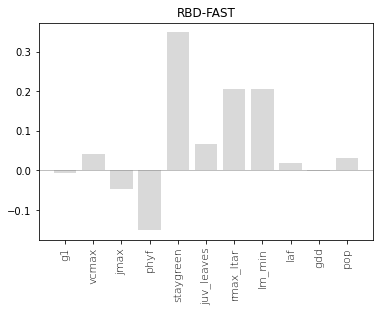

In [14]:
problem, param_values = params_sample('present', 100)
df_params = df_params[:100]
ear = df_all.groupby('cvar').mean().dm_ear

X = df_params.to_numpy()
Y = np.array(ear)
Si = rbd_fast.analyze(problem, X, Y, print_to_console=False)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
ax.bar(params_list, Si['S1'], color='#d9d9d9')
ax.set_title('RBD-FAST')

plt.axhline(y=0, color='grey', linewidth=0.5)
plt.xticks(rotation=90, fontsize=11, weight='light')

### Where to add in scatter plot type analyses?
Also can't find where the old code is used to plot it..

### Cluster based on site-year climate info
- Treating each site-year as individual samples
- One down side with treating each site-year as individuals is that it's hard to relate to the clustered groups. Can't project back onto a map.
- Can think about tweaking what features to use to cluster sites, but I don't think it'll make a big difference.
- Q: should I pre-process before clustering?

In [17]:
#df_climate = df_all[['temp', 'temp_var', 'vpd', 'rh_var', 'precip', 'precip_var', 'solrad']]
df_climate = df_all[['temp', 'vpd', 'precip']]

kmeans_mod = KMeans(n_clusters=4)
kmeans_mod.fit(df_climate)
y_kmeans = kmeans_mod.predict(df_climate)

df_cluster = df_all.copy()
df_cluster['group'] = y_kmeans

df_km0 = df_cluster.query('group==0')
df_km1 = df_cluster.query('group==1')
df_km2 = df_cluster.query('group==2')
df_km3 = df_cluster.query('group==3')

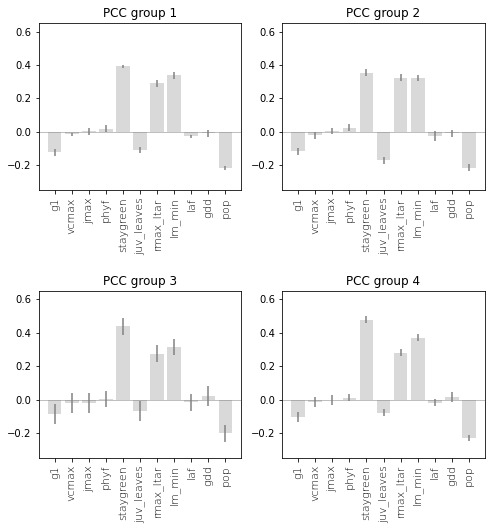

In [16]:
df_kms = [df_km0, df_km1, df_km2, df_km3]
params_list = list(df_params.columns[:-1])

fig = plt.figure(figsize=(8,8))

for num in np.arange(len(df_kms)):
    rs = []
    ps = []
    cis = []
    ax = fig.add_subplot(2,2,num+1)
    
    for item in np.arange(11):
        param = params_list[item]
        select = list(np.arange(11))
        select.remove(item)
        params_sub = [params_list[item] for item in select]
        pcc = pg.partial_corr(df_kms[num], x=param, y='dm_ear',
                              x_covar=params_sub)
        rs.append(pcc['r']['pearson'])
        ps.append(pcc['p-val']['pearson'])
        cis.append(pcc['CI95%']['pearson'])

    errs = [np.round(np.abs(cis[item][0] - cis[item][1]),2) for item in np.arange(len(cis))]

    ax.bar(params_list, rs, color='#d9d9d9',
           yerr=errs, ecolor='grey')
    ax.set_title(f'PCC group {num+1}')
    ax.set_ylim(-0.35, 0.65)

    plt.axhline(y=0, color='grey', linewidth=0.5)
    plt.xticks(rotation=90, fontsize=11, weight='light')

fig.subplots_adjust(wspace=0.2, hspace=0.6)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/pcc_cspace.png', format='png', dpi=800)

### Try clustering based on various methods
- k-means clustering based on individual site-years
- k-means clustering based on site
- k-means clustering based on sites + soil info
- manula clustering based on temperature & VPD

### Cluster based on site

In [4]:
#df_climate = df_all[['temp', 'temp_var', 'vpd', 'rh_var', 'precip', 'precip_var', 'solrad']]
df_climate = df_all.groupby('site').mean()[['temp', 'vpd', 'precip']]

kmeans_mod = KMeans(n_clusters=4)
kmeans_mod.fit(df_climate)
y_kmeans = kmeans_mod.predict(df_climate)

df_cluster = df_climate.copy()
df_cluster['group'] = y_kmeans

df_km0 = df_cluster.query('group==0')
df_km1 = df_cluster.query('group==1')
df_km2 = df_cluster.query('group==2')
df_km3 = df_cluster.query('group==3')

df_clustered_sites = pd.merge(df_cluster, df_sites, left_on='site', right_on='site')

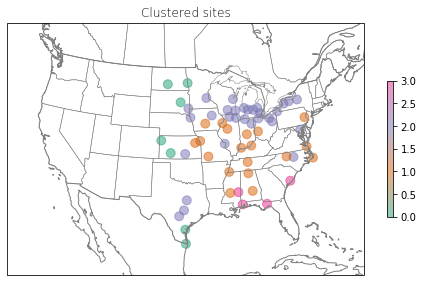

In [108]:
fig = plt.figure(figsize=(8,5))
extent = [-123, -72, 19, 53]

ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))
mp = ax.scatter(df_clustered_sites.lon, df_clustered_sites.lat, 
           c=df_clustered_sites.group, cmap=Dark2_4.mpl_colormap, 
           s=80, alpha=0.5,
           transform=ccrs.PlateCarree())
ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('Clustered sites', fontweight='light', size=12)

fig.colorbar(mp, shrink=0.5)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/map_clustered_sites.png', format='png', dpi=800)

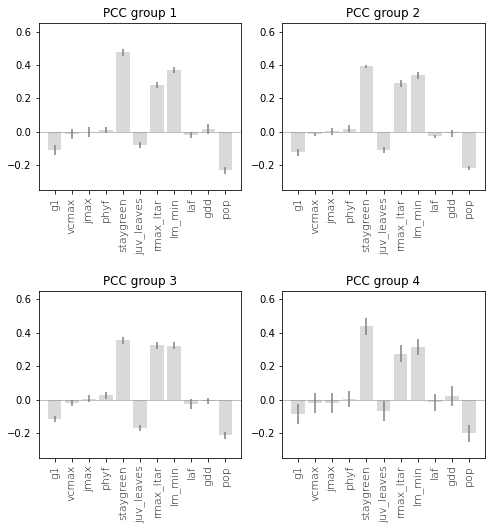

In [109]:
df_kms = [df_km0, df_km1, df_km2, df_km3]
params_list = list(df_params.columns[:-1])

fig = plt.figure(figsize=(8,8))

for num in np.arange(len(df_kms)):
    rs = []
    ps = []
    cis = []
    ax = fig.add_subplot(2,2,num+1)
    
    for item in np.arange(11):
        param = params_list[item]
        select = list(np.arange(11))
        select.remove(item)
        params_sub = [params_list[item] for item in select]
        pcc = pg.partial_corr(df_kms[num], x=param, y='dm_ear',
                              x_covar=params_sub)
        rs.append(pcc['r']['pearson'])
        ps.append(pcc['p-val']['pearson'])
        cis.append(pcc['CI95%']['pearson'])

    errs = [np.round(np.abs(cis[item][0] - cis[item][1]),2) for item in np.arange(len(cis))]

    ax.bar(params_list, rs, color='#d9d9d9',
           yerr=errs, ecolor='grey')
    ax.set_title(f'PCC group {num+1}')
    ax.set_ylim(-0.35, 0.65)

    plt.axhline(y=0, color='grey', linewidth=0.5)
    plt.xticks(rotation=90, fontsize=11, weight='light')

fig.subplots_adjust(wspace=0.2, hspace=0.6)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/pcc_cspace.png', format='png', dpi=800)